In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
%matplotlib inline
from numpy import asarray

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        # in old Python versions:
        # if seen.has_key(marker)
        # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

# Data

In [3]:
# t1 is for Cx and t2 is for rCO2 (both are in hours)
t1 = [1.5, 2.5, 3.5, 4.5, 5.5] 
t2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25] 

In [4]:
# A4
Cx_4_A = [0.9047584, 1.0947344, 1.494496, 1.9289308, 2.432712] # g/L
rco2_4_A = [3.12, 4.02, 4.94, 5, 6.24, 7.22, 8.2, 9.22, 9.8] # ml/min

In [5]:
# B4
Cx_4_B = [0.972, 0.975, 1.4, 1.48, 1.82] # g/L
rco2_4_B = [2.07, 2.89, 3.49, 4.21, 5.14, 6.98, 8.25, 9.09, 9.65] # ml/min

In [6]:
# C4
Cx_4_C = [0.9039936, 0.963648, 1.5332484, 1.8840596, 2.3654052] # g/L
rco2_4_C = [1.8533, 2.7467, 3.2333, 5.1067, 5.8467, 6.4, 7.1933, 9.0533, 9.3333] # ml/min

In [7]:
Cx_4_avg=[]
for index,value in enumerate(Cx_4_A):
    sum_avg=Cx_4_A[index]+Cx_4_B[index]+Cx_4_C[index]
    Cx_4_avg.append(sum_avg/3)

Cx_4_avg

[0.9269173333333333,
 1.0111274666666668,
 1.4759148,
 1.7643301333333337,
 2.206039066666667]

In [8]:
rco2_4_avg=[]
for index,value in enumerate(rco2_4_A):
    sum_avg=rco2_4_A[index]+rco2_4_C[index]+rco2_4_B[index]
    rco2_4_avg.append(sum_avg/3)
rco2_4_avg

[2.347766666666667,
 3.2189,
 3.8877666666666673,
 4.772233333333333,
 5.742233333333334,
 6.866666666666667,
 7.8811,
 9.1211,
 9.594433333333333]

In [9]:
alpha, beta, theta = 0.1, 0.1, 0.05
mu, gamma = 0.235, 1.45
Km = 0.00001

# Mu Fit Exp 4

In [10]:
t1_array = numpy.array([1.5, 2.5, 3.5, 4.5, 5.5])
t2_array = numpy.array([0,1.5, 2.5, 3.5, 4.5, 5.5])

In [11]:
def bio(t,mu1,CA0):

    return CA0*scipy.e**(mu1*(t))

In [12]:
params = scipy.optimize.curve_fit(bio,t1_array,Cx_4_avg,p0 =(0.5,0.5))[0]
mu_fit,Ca0_fit = params

print (mu_fit,Ca0_fit)

Cx_fit= bio(t2_array,mu_fit,Ca0_fit)



0.2289417667931329 0.629329371011377


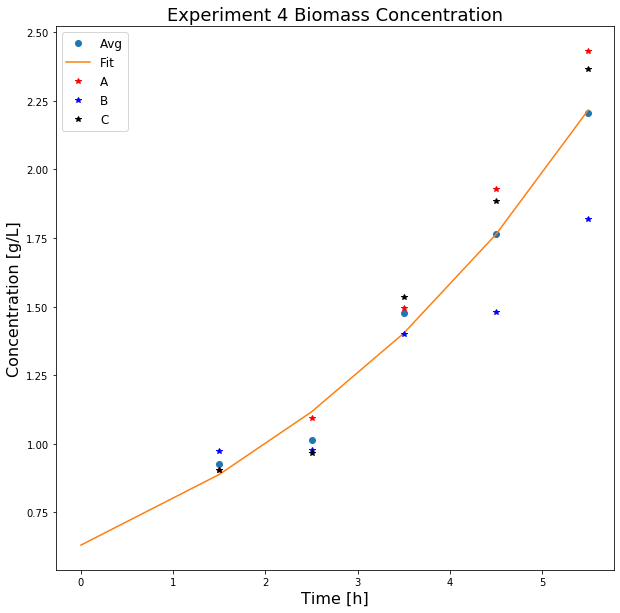

In [13]:
plt.figure(figsize=(10,10))

plt.title('Experiment 4 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t1,Cx_4_avg,"o", label = "Avg")
plt.plot(t2_array,Cx_fit, label = "Fit")

plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')

plt.legend(loc='best', fontsize = 12)
plt.savefig('Mu_fit_E3.jpeg',dpi=1000)


In [14]:
Cx_fit[0]

0.629329371011377

In [15]:
mu = mu_fit
mu

0.2289417667931329

# Fitting Gamma

In [16]:
t3_array = numpy.array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])

In [17]:
T = 22 + 273.15
P = 101.325 #kPa

In [18]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [19]:
def response_fun(C):
    
    Cx, Ce, Cs = C[0],C[1], C[2]
    
    mu1=mu*Cs/(Km+Cs)
    theta1=theta
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    C = numpy.matrix([0, 0, 0, theta1, mu1]).T
    r = numpy.linalg.solve(S, C) 
        
    
    return [mu,        # biomass
            r[4,0],    # ethanol   
            r[0, 0]]    

In [20]:
def ferm_eq(t,C):
    Cx, Ce, Cs = C[0],C[1], C[2]   
    r=response_fun([Cx, Ce, Cs])
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [21]:
error = 1000
gamma_span = numpy.arange(0,2,0.001)

for gamma in gamma_span:
    
    squares = 0
    
    #Initial Concentrations at T=1.5
    Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
    Ce0=0 #Non zero but low Ethanol Concentration
    Cg0=(25*2)/30 #Glucose as initially added
    Co=[Cx0, Ce0, Cg0]
    
    tspan = [0,6]

    C_sol=numpy.array([[],[],[]])
    t_sol=numpy.array([])
    
    for index,time in enumerate(t_important):

        if index==0:
            pass

        else:
            t_span=[t_important[index-1],time]
            teval=numpy.arange(t_important[index-1],time+0.5,0.5)
#             print (teval)

            C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#             print (C.y)

            C_sol=numpy.concatenate((C_sol,C.y),axis=1)

            Cx0 = C.y[0,-1]
            Ce0 = C.y[1,-1]
            Cg0 = C.y[2,-1]+((5*2)/30)
            Co=[Cx0, Ce0, Cg0]

            t_sol=numpy.concatenate((t_sol,teval))
            
            
            
    C_x_unique = numpy.array(uniquify(C_sol[0]))
    
#     Cx_u_2 = bio(t3_array,mu,Cx_fit[0])
    
    rco2_fit = []
    
    print (C_x_unique*24.6, gamma, Cx0)
    
    for index,value in enumerate(rco2_4_avg):
        
        rates = response_fun((C_sol[0][index], C_sol[1][index], C_sol[2][index]))

        rx, re, rs = rates

    
        fitted_rco2 = (0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(C_x_unique[index]*24.6)/24.6*0.5

        squares+=(fitted_rco2-value)**2

        rco2_fit.append(fitted_rco2)
            
    if squares<error:
            
        gamma_acc=gamma
        error=squares
        rco2_fit_acc=rco2_fit

gamma_acc, mu

[0.62932937 0.70565447 0.79123621 0.88719733 0.9947969  1.11544561
 1.25072685 1.40241509 1.5724999  1.76321343 1.97705541 2.21683259
 2.48569003] 0.0 0.10104431029827515
[0.62932937 0.70565447 0.79123621 0.88719733 0.9947969  1.11544561
 1.25072685 1.40241509 1.5724999  1.76321343 1.97705541 2.21683259
 2.48569003] 0.001 0.10104431029090649
[0.62932937 0.70565447 0.79123621 0.88719733 0.9947969  1.11544561
 1.25072685 1.40241509 1.5724999  1.76321343 1.97705541 2.21683259
 2.48569003] 0.002 0.10104431028358911
[0.62932937 0.70565447 0.79123621 0.88719733 0.9947969  1.11544561
 1.25072685 1.40241509 1.5724999  1.76321343 1.97705541 2.21683259
 2.48569003] 0.003 0.10104431027632242
[0.62932937 0.70565447 0.79123621 0.88719733 0.9947969  1.11544561
 1.25072685 1.40241509 1.5724999  1.76321343 1.97705541 2.21683259
 2.48569003] 0.004 0.10104431026910608
[0.62932937 0.70565447 0.79123621 0.88719733 0.9947969  1.11544561
 1.25072685 1.40241509 1.5724999  1.76321343 1.97705541 2.21683259
 2.

[0.62932937 0.70565447 0.79123621 0.88719733 0.99479689 1.11544561
 1.25072685 1.40241509 1.57249989 1.76321343 1.97705541 2.21683259
 2.48569002] 0.058 0.1010443099428647
[0.62932937 0.70565447 0.79123621 0.88719733 0.99479689 1.11544561
 1.25072685 1.40241509 1.57249989 1.76321343 1.9770554  2.21683259
 2.48569002] 0.059000000000000004 0.10104430993782232
[0.62932937 0.70565447 0.79123621 0.88719733 0.99479689 1.11544561
 1.25072685 1.40241509 1.57249989 1.76321343 1.9770554  2.21683259
 2.48569002] 0.06 0.10104430993281081
[0.62932937 0.70565447 0.79123621 0.88719733 0.99479689 1.11544561
 1.25072685 1.40241509 1.57249989 1.76321343 1.9770554  2.21683259
 2.48569002] 0.061 0.10104430992782988
[0.62932937 0.70565447 0.79123621 0.88719733 0.99479689 1.11544561
 1.25072685 1.40241509 1.57249989 1.76321343 1.9770554  2.21683259
 2.48569002] 0.062 0.1010443099228793
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.11544561
 1.25072685 1.40241509 1.57249989 1.76321343 1.9770554  

[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.9770554  2.21683258
 2.48569002] 0.111 0.10104430971306505
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.9770554  2.21683258
 2.48569002] 0.112 0.1010443097093713
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.9770554  2.21683258
 2.48569002] 0.113 0.10104430970569818
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.9770554  2.21683258
 2.48569002] 0.114 0.10104430970204561
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.9770554  2.21683258
 2.48569002] 0.115 0.1010443096984135
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.9770554  2.21683258
 2.485690

 2.48569001] 0.171 0.1010443095236419
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569001] 0.17200000000000001 0.10104430952097043
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569001] 0.17300000000000001 0.10104430951831271
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569001] 0.17400000000000002 0.10104430951566885
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569001] 0.17500000000000002 0.10104430951303857
[0.62932937 0.70565446 0.79123621 0.88719733 0.99479689 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569001] 0.176 0.10104430951042204
[0.62932937 0.70565446 0.79123621 0.88719733 0

 2.48569001] 0.233 0.10104430938128428
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 0.234 0.10104430937933107
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 0.23500000000000001 0.10104430937738743
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 0.23600000000000002 0.10104430937545332
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 0.23700000000000002 0.10104430937352865
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 0.23800000000000002 0.10104430937161347
[0.62932937 0.70565445 0.79123621 0.88719732 

 2.48569001] 0.291 0.10104430928232778
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.292 0.10104430928085208
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.293 0.10104430927938333
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.294 0.10104430927792162
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.295 0.10104430927646685
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.296 0.10104430927501894
[0.62932937 0.70565445 0.79123621 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1

 2.48569001] 0.35000000000000003 0.10104430920618475
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.35100000000000003 0.10104430920506799
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.352 0.10104430920395648
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.353 0.10104430920285011
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.354 0.10104430920174885
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569001] 0.355 0.10104430920065292
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.2507

 2.48569   ] 0.41300000000000003 0.10104430914515015
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569   ] 0.41400000000000003 0.10104430914432024
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569   ] 0.41500000000000004 0.10104430914349403
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569   ] 0.41600000000000004 0.1010443091426719
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569   ] 0.417 0.10104430914185356
[0.62932937 0.70565445 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705539 2.21683257
 2.48569   ] 0.418 0.10104430914103926
[0.62932937 0.70565445 0.79123622 0.88719732 0

 2.48569   ] 0.464 0.10104430910748818
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.465 0.10104430910683834
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.466 0.10104430910619151
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.467 0.10104430910554797
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.468 0.10104430910490744
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.46900000000000003 0.10104430910427001
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.4024150

[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.518 0.1010443090766042
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.519 0.10104430907610752
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.52 0.10104430907561339
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.521 0.10104430907512177
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.522 0.10104430907463272
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569 

 2.48569   ] 0.5680000000000001 0.101044309054693
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.5690000000000001 0.10104430905431182
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.5700000000000001 0.10104430905393273
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.5710000000000001 0.10104430905355576
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.5720000000000001 0.1010443090531808
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.5730000000000001 0.10104430905280798
[0.62932937 0.70565444 0.7

 2.48569   ] 0.623 0.10104430903663995
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.624 0.10104430903636305
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.625 0.10104430903608784
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.626 0.1010443090358143
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.627 0.10104430903554246
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.628 0.10104430903527234
[0.62932937 0.70565444 0.79123622 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.

 2.48569   ] 0.683 0.10104430902285008
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.684 0.10104430902266572
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.685 0.1010443090224826
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.686 0.10104430902230088
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.687 0.10104430902212053
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.6880000000000001 0.10104430902194156
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 

 2.48569   ] 0.737 0.10104430901475578
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.738 0.10104430901463958
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.739 0.10104430901452463
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.74 0.10104430901441075
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.741 0.10104430901429812
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 0.742 0.10104430901418643
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.

 2.48569   ] 0.797 0.10104430900970057
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.798 0.10104430900964725
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.799 0.1010443090095949
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.8 0.10104430900954338
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.801 0.1010443090094928
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.802 0.10104430900944313
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.763

 2.48569   ] 0.851 0.10104430900810109
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.852 0.10104430900809477
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.853 0.10104430900808924
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.854 0.10104430900808445
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.855 0.10104430900808048
[0.62932937 0.70565444 0.79123623 0.88719732 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.856 0.10104430900807732
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1

 2.48569   ] 0.905 0.10104430900883989
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.906 0.10104430900887329
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.907 0.10104430900890725
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.908 0.10104430900894193
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.909 0.10104430900897732
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.91 0.10104430900901336
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.

 2.48569   ] 0.9580000000000001 0.10104430901149042
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.9590000000000001 0.10104430901155684
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.96 0.10104430901162383
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.961 0.10104430901169138
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.962 0.10104430901175955
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 0.963 0.10104430901182826
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.2507268

 2.48569   ] 1.012 0.1010443090158582
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.0130000000000001 0.10104430901595333
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.014 0.10104430901604897
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.0150000000000001 0.10104430901614513
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.016 0.1010443090162416
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.0170000000000001 0.10104430901633879
[0.62932937 0.70565444 0.79123623 0.88719733 0.99479688 1.115445

 2.48569   ] 1.063 0.10104430902130443
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.064 0.10104430902142275
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.065 0.1010443090215415
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.066 0.10104430902166067
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.067 0.10104430902178022
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.068 0.10104430902190031
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.

 2.48569   ] 1.113 0.10104430902771423
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.114 0.10104430902785222
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.115 0.1010443090279906
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.116 0.10104430902812923
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.117 0.1010443090282684
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.118 0.10104430902840783
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7

 2.48569   ] 1.182 0.10104430903803781
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.183 0.10104430903819872
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.184 0.10104430903835984
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.185 0.10104430903852123
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.186 0.10104430903868297
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.187 0.101044309038845
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7

 2.48569   ] 1.236 0.10104430904713037
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.237 0.10104430904730613
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.238 0.1010443090474822
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.239 0.10104430904765847
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.24 0.10104430904783507
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.241 0.10104430904801193
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7

 2.48569   ] 1.295 0.10104430905791906
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.296 0.10104430905810874
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.297 0.10104430905829873
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.298 0.1010443090584889
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.299 0.10104430905867921
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.3 0.10104430905886982
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76

 2.48569   ] 1.354 0.10104430906946472
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.355 0.10104430906966622
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.356 0.1010443090698679
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.357 0.10104430907006984
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.358 0.10104430907027181
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.359 0.10104430907047413
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.

 2.48569   ] 1.415 0.10104430908207208
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.416 0.10104430908228382
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.417 0.10104430908249577
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.418 0.10104430908270773
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.419 0.10104430908291992
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.42 0.10104430908313229
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.

 2.48569   ] 1.475 0.1010443090950307
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.476 0.10104430909525083
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.477 0.10104430909547107
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.478 0.10104430909569148
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.479 0.101044309095912
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.48 0.10104430909613263
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.763

 2.48569   ] 1.537 0.10104430910890598
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.538 0.10104430910913337
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.539 0.10104430910936077
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.54 0.10104430910958838
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.541 0.10104430910981596
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.542 0.1010443091100438
[0.62932937 0.70565444 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7

 2.48569   ] 1.589 0.1010443091208614
[0.62932937 0.70565443 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.59 0.10104430912109379
[0.62932937 0.70565443 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.591 0.10104430912132631
[0.62932937 0.70565443 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.592 0.10104430912155891
[0.62932937 0.70565443 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.593 0.10104430912179162
[0.62932937 0.70565443 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7632134  1.97705538 2.21683257
 2.48569   ] 1.594 0.10104430912202438
[0.62932937 0.70565443 0.79123624 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.7

 2.48569   ] 1.6420000000000001 0.10104430913329693
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 1.643 0.10104430913353366
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 1.6440000000000001 0.10104430913377066
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 1.645 0.10104430913400753
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 1.6460000000000001 0.10104430913424459
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249988 1.76321341 1.97705538 2.21683257
 2.48569   ] 1.647 0.10104430913448158
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154

 2.48569001] 1.694 0.10104430917627542
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.695 0.10104430917808842
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.696 0.1010443091799044
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.697 0.1010443091817235
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.698 0.10104430918354547
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.699 0.10104430918537066
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072684 1.40241508 1.57249989 1.7

 2.48569001] 1.745 0.10104430927244641
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.746 0.10104430927440441
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.747 0.10104430927636496
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321341 1.97705538 2.21683257
 2.48569001] 1.748 0.10104430927832815
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 1.749 0.10104430928029401
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241508 1.57249989 1.76321341 1.97705539 2.21683257
 2.48569001] 1.75 0.10104430928226253
[0.62932937 0.70565443 0.79123625 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241508 1.57249989 1.

 2.48569001] 1.81 0.10104430940492184
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.811 0.10104430940703783
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.812 0.10104430940915615
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.813 0.10104430941127654
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.814 0.10104430941339924
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.815 0.10104430941552409
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.

 2.48569001] 1.862 0.1010443095177701
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.863 0.10104430951999398
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.864 0.10104430952221968
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.865 0.10104430952444737
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.866 0.10104430952667692
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569001] 1.867 0.10104430952890843
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.

 2.48569002] 1.913 0.10104430963353273
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569002] 1.9140000000000001 0.10104430963584825
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569002] 1.915 0.10104430963816546
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569002] 1.9160000000000001 0.10104430964048429
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569002] 1.917 0.10104430964280481
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321341 1.97705539 2.21683258
 2.48569002] 1.9180000000000001 0.101044309645127
[0.62932937 0.70565443 0.79123626 0.88719733 0.99479688 1.115445

 2.48569002] 1.969 0.10104430976564763
[0.62932937 0.70565443 0.79123627 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569002] 1.97 0.10104430976804982
[0.62932937 0.70565443 0.79123627 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569002] 1.971 0.10104430977045335
[0.62932937 0.70565443 0.79123627 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569002] 1.972 0.10104430977285828
[0.62932937 0.70565443 0.79123627 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569002] 1.973 0.10104430977526459
[0.62932937 0.70565443 0.79123627 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.76321342 1.97705539 2.21683258
 2.48569002] 1.974 0.1010443097776725
[0.62932937 0.70565443 0.79123627 0.88719733 0.99479688 1.1154456
 1.25072685 1.40241509 1.57249989 1.7

(1.212, 0.2289417667931329)

In [22]:
gamma_acc, mu, error

(1.212, 0.2289417667931329, 4.74556127904877)

In [23]:
rco2_fit = rco2_fit_acc
rco2_fit

[3.7096602823542764,
 4.1595680982209045,
 4.664040975494221,
 5.2296959460525,
 5.863959396548845,
 6.575139276962175,
 7.372572582911456,
 8.266719175824612,
 9.269310951847837]

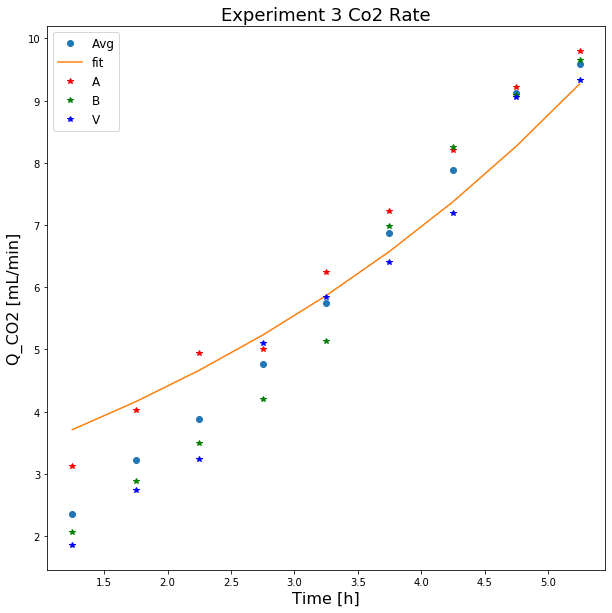

In [24]:
plt.figure(figsize=(10,10))

plt.title('Experiment 3 Co2 Rate', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Q_CO2 [mL/min]', fontsize = 16)

plt.plot(t2,rco2_4_avg,"o", label='Avg')

plt.plot(t3_array,rco2_fit, label='fit')

plt.plot(t2,rco2_4_A,"*r", label='A')
plt.plot(t2,rco2_4_B,"*g", label='B')
plt.plot(t2,rco2_4_C,"*b", label='V')


plt.legend(loc='best', fontsize = 12)

plt.savefig('Rco2_E3.jpeg',dpi=1000)

# Plot Theory To Data

In [25]:
gamma = gamma_acc
# gamma = 1.45
mu, gamma

(0.2289417667931329, 1.212)

In [26]:
#Initial Concentrations at T=1.5

Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
print (Cx0, "g/L")

Ce0=0.1 #Non zero but low Ethanol Concentration

Cg0=(25*2)/30 #Glucose as initially added

Co=[Cx0, Ce0, Cg0]

0.025582494756560038 g/L


In [27]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [28]:
C_sol=numpy.array([[],[],[]])
t_sol=numpy.array([])

for index,time in enumerate(t_important):
#     print (index,time)    
    
    if index==0:
        pass
    
    else:
        t_span=[t_important[index-1],time]
#         print (t_span)
        teval=numpy.arange(t_important[index-1],time+0.5,0.5)
        print (teval)
        C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#         print (C_sol,C.y)
        print (C.y)
        C_sol=numpy.concatenate((C_sol,C.y),axis=1)
        
#         print (Co, "Co pre")
        Cx0 = C.y[0,-1]
        Ce0 = C.y[1,-1]
        Cg0 = C.y[2,-1]+((5*2)/30)
        Co=[Cx0, Ce0, Cg0]
        t_sol=numpy.concatenate((t_sol,teval))
#         print (Co, "Co post")
    
print(C_sol, t_sol)

#There is a duplication of times, which is intentional to allow for plotting of the discontinous glucose concentrations

[0.  0.5 1.  1.5]
[[0.02558249 0.02868515 0.03216408 0.03606494]
 [0.1        0.10949654 0.12014476 0.13208442]
 [1.66666667 1.68525518 1.70609797 1.72946862]]
[1.5 2.  2.5 3. ]
[[0.03606494 0.04043891 0.04534333 0.05084257]
 [0.13208442 0.14547219 0.16048353 0.17731548]
 [2.06280196 2.08900715 2.11839032 2.15133714]]
[3.  3.5 4. ]
[[0.05084257 0.05700875 0.06392277]
 [0.17731548 0.19618884 0.21735115]
 [2.48467047 2.52161314 2.56303618]]
[4.  4.5 5.  5.5 6. ]
[[0.06392277 0.07167537 0.08036813 0.09011517 0.10104434]
 [0.21735115 0.24108015 0.26768683 0.2975204  0.33097222]
 [2.89636952 2.94281662 2.99489647 3.05329262 3.11877114]]
[[0.02558249 0.02868515 0.03216408 0.03606494 0.03606494 0.04043891
  0.04534333 0.05084257 0.05084257 0.05700875 0.06392277 0.06392277
  0.07167537 0.08036813 0.09011517 0.10104434]
 [0.1        0.10949654 0.12014476 0.13208442 0.13208442 0.14547219
  0.16048353 0.17731548 0.17731548 0.19618884 0.21735115 0.21735115
  0.24108015 0.26768683 0.2975204  0.3309

In [29]:
Cx=C_sol[0]*24.6             
print (Cx)
Ce=C_sol[1]*23

Cx_u = uniquify(numpy.array(Cx))
Cx_u

[0.62932937 0.70565476 0.79123636 0.88719744 0.88719744 0.99479721
 1.11544592 1.2507271  1.2507271  1.40241537 1.57250021 1.57250021
 1.763214   1.97705605 2.21683313 2.48569066]


[0.629329371011377,
 0.7056547636577739,
 0.7912363642143865,
 0.8871974418370623,
 0.9947972101404913,
 1.1154459186142847,
 1.2507271033164722,
 1.4024153667733112,
 1.5725002096071032,
 1.7632139985924098,
 1.9770560534846304,
 2.216833127937199,
 2.485690659633323]

In [30]:
# Cx_plot = numpy.concatenate((numpy.array([Cx_fit[0]]),Cx))
# t_sol_plot = numpy.concatenate((numpy.array([0]),t_sol))

In [31]:
Cx, t_sol

(array([0.62932937, 0.70565476, 0.79123636, 0.88719744, 0.88719744,
        0.99479721, 1.11544592, 1.2507271 , 1.2507271 , 1.40241537,
        1.57250021, 1.57250021, 1.763214  , 1.97705605, 2.21683313,
        2.48569066]),
 array([0. , 0.5, 1. , 1.5, 1.5, 2. , 2.5, 3. , 3. , 3.5, 4. , 4. , 4.5,
        5. , 5.5, 6. ]))

In [32]:
# Cx_plot, t_sol_plot

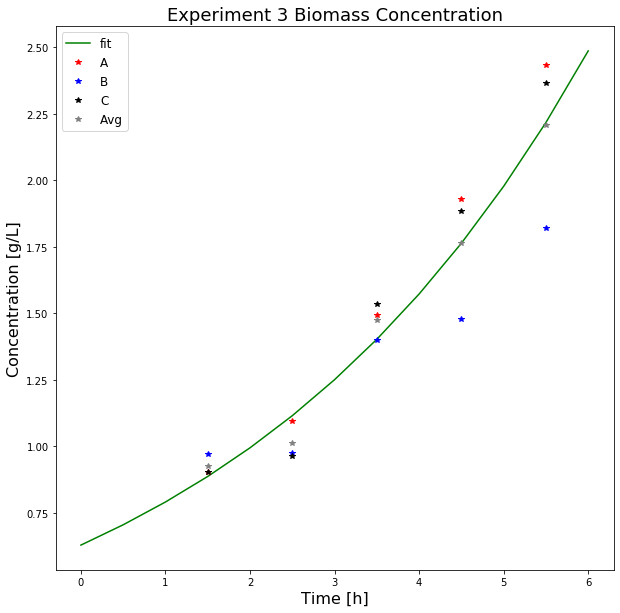

In [33]:
plt.figure(figsize=(10,10))

plt.title('Experiment 3 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t_sol, Cx, "-",color='green',label='fit')
plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')
plt.plot(t1, Cx_4_avg, '*', color='grey', label='Avg')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Cx_E3.jpeg',dpi=1000)

plt.show()



In [34]:
mu, gamma

(0.2289417667931329, 1.212)